In [1]:
#### Use the unstable kernel for the analysis of CCEW
import xarray as xr
import numpy as np
import healpy as hp
import intake
import datetime
import easygems.healpix as egh

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
####only for the first time
#!pip install /work/mh0731/m300876/package/git_repository/pywk99

Defaulting to user installation because normal site-packages is not writeable
Processing /work/mh0731/m300876/package/git_repository/pywk99
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pywk99: filename=pywk99-0.4.3-py3-none-any.whl size=25547 sha256=89433ae5b9f16bb9a02cdb8404f4c22543c4c14d418a07f83b3e5284dff9fe9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4he73bua/wheels/8a/3c/3b/fd2f0c20bc12b60935ab5ec9095090858bce165de14e9187ed
Successfully built pywk99


In [2]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [3]:
from pywk99.spectrum import get_power_spectrum, get_background_spectrum
from pywk99.timeseries import remove_linear_trend, remove_seasonal_cycle
from pywk99.spectrum import plot_spectrum, plot_spectrum_peaks
from pywk99.waves import plot_dispersion_relations
from pywk99.filter import get_wave_filter_window, get_box_filter_window
from pywk99.filter import get_mjo_window, get_tropical_depression_window
from pywk99.filter import filter_variable

In [4]:
import dask
from dask.distributed import Client
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
client = Client()

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computa

In [5]:
def get_wk99_spectrums(variable, grid_type="latlon", grid_dict=None):
    new_variable = remove_seasonal_cycle(variable)
    new_variable = remove_linear_trend(new_variable)
    window_length = "92D"
    overlap_length = "60D"
    data_frequency = "12h"
    symmetric_spectrum = get_power_spectrum(
        new_variable,
        "symmetric",
        data_frequency,
        window_length,
        overlap_length,
        grid_type=grid_type,
        grid_dict=grid_dict,
    )
    asymmetric_spectrum = get_power_spectrum(
        new_variable,
        "asymmetric",
        data_frequency,
        window_length,
        overlap_length,
        grid_type=grid_type,
        grid_dict=grid_dict,
    )
    background_spectrum = get_background_spectrum(
        symmetric_spectrum, asymmetric_spectrum
    )
    return symmetric_spectrum, asymmetric_spectrum, background_spectrum

# Analysis

## Open datasets

Please note the following:
- ICON's data is currently obtained from zarr files. This should be changed so that the data comes from the intake catalog.
- A linear interpolation of the model data is made to account for missing simulated days in June. This should be unnecessary when using the intake catalog.
- For both observations and simulations, and to allow direct comparison, the wave-frequency spectra is computed on the same healpix zoom 5 grid. This means that NOAA's OLR is first interpolated to healpix. 

Downloading NOAA OLR data and its interpolation to a healpix grid is done as follows:
```bash
wget https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.2xdaily.1979-2022.nc
cdo remapbil,hpz5 olr.2xdaily.1979-2022.nc olr.hpz5.2xdaily.1979-2022.nc
```


In [6]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-02-01", "2021-01-31")
ds_icon = (
    experiment(zoom=5, time="PT6H", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .sel(time=time_slice)
)


CPU times: user 1.8 s, sys: 503 ms, total: 2.3 s
Wall time: 3.25 s


In [7]:
# Using one year of model data
icon_olr = ds_icon.rlut.compute()
icon_olr = icon_olr.dropna("time")
icon_olr = icon_olr.resample(time="12h", closed="right", label="right", offset="6h").mean()
icon_olr = icon_olr.interpolate_na("time") # interpolate missing dates linearly (some days missing in June)
icon_olr = icon_olr.sel(time=time_slice)

In [8]:
# Noaa OLR resampled to healpix grid, one year of data
zoom = 5
noaa_olr = xr.open_dataset(f"/work/mh0081/m301047/ccew_hackaton/olr.hpz{zoom}.2xdaily.1979-2022.nc")
noaa_olr = noaa_olr.olr
noaa_olr = noaa_olr.sel(time=time_slice)
noaa_olr = noaa_olr.compute()

## Compute spectra and spectral peaks

In [9]:
# define grid_dict for analysis
grid_dict = dict(nside=ds_icon.crs.healpix_nside,
                 nest=ds_icon.crs.healpix_order == "nest",
                 minmax_lat=15)

In [10]:
# Compute model spectra
icon_symmetric, icon_asymmetric, icon_background = get_wk99_spectrums(
    icon_olr, grid_type="healpix", grid_dict=grid_dict
)
icon_symmetric = icon_symmetric.sel(wavenumber=slice(-20, 20))
icon_asymmetric = icon_asymmetric.sel(wavenumber=slice(-20, 20))
icon_background = icon_background.sel(wavenumber=slice(-20, 20))

/home/m/m300876/.local/lib/python3.10/site-packages/pywk99/timeseries/timeseries.py:34: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_time_span = data_time_span.astype("timedelta64[D]")


In [11]:
# Observations spectra
noaa_symmetric, noaa_asymmetric, noaa_background = get_wk99_spectrums(
    noaa_olr, grid_type="healpix", grid_dict=grid_dict
)
noaa_symmetric = noaa_symmetric.sel(wavenumber=slice(-20, 20))
noaa_asymmetric = noaa_asymmetric.sel(wavenumber=slice(-20, 20))
noaa_background = noaa_background.sel(wavenumber=slice(-20, 20))

/home/m/m300876/.local/lib/python3.10/site-packages/pywk99/timeseries/timeseries.py:34: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_time_span = data_time_span.astype("timedelta64[D]")


In [12]:
# Difference
diff_symmetric = np.log10(icon_symmetric) - np.log10(noaa_symmetric)
diff_asymmetric = np.log10(icon_asymmetric) - np.log10(noaa_asymmetric)
diff_background = np.log10(icon_background) - np.log10(noaa_background)

In [13]:
# spectral peaks model
icon_symmetric_peaks = icon_symmetric / icon_background
icon_asymmetric_peaks = icon_asymmetric / icon_background
# spectral peaks observations
noaa_symmetric_peaks = noaa_symmetric / noaa_background
noaa_asymmetric_peaks = noaa_asymmetric / noaa_background

## Filter for diferent wave types

In [14]:
# Define filter windows
kelvin_window = get_wave_filter_window(
    "kelvin", k_min=1, k_max=14, w_min=0.075, w_max=0.4, h_min=8, h_max=90
)
rossby_window = get_wave_filter_window(
    "equatorial_rossby",
    k_min=-14,
    k_max=1,
    w_min=0.0,
    w_max=0.4,
    h_min=4,
    h_max=90,
)
mixed_rossby_window = get_wave_filter_window(
    "mixed_rossby_gravity",
    k_min=-12,
    k_max=12,
    w_min=0.075,
    w_max=1,
    h_min=8,
    h_max=90,
)
ig_window = get_wave_filter_window(
    "inertio_gravity",
    k_min=-14,
    k_max=1,
    w_min=0.3,
    w_max=1,
    h_min=8,
    h_max=90,
)
mjo_window = get_mjo_window()
td_window = get_tropical_depression_window()
filters = [
    kelvin_window,
    rossby_window,
    mixed_rossby_window,
    ig_window,
    mjo_window,
    td_window,
]

In [15]:
# Filter fields
filtered_icon = filter_variable(
    icon_olr, filters, grid_type="healpix", grid_dict=grid_dict
)
filtered_noaa = filter_variable(
    noaa_olr, filters, grid_type="healpix", grid_dict=grid_dict
)

/home/m/m300876/.local/lib/python3.10/site-packages/pywk99/timeseries/timeseries.py:34: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_time_span = data_time_span.astype("timedelta64[D]")
/home/m/m300876/.local/lib/python3.10/site-packages/pywk99/timeseries/timeseries.py:34: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np

# Plots

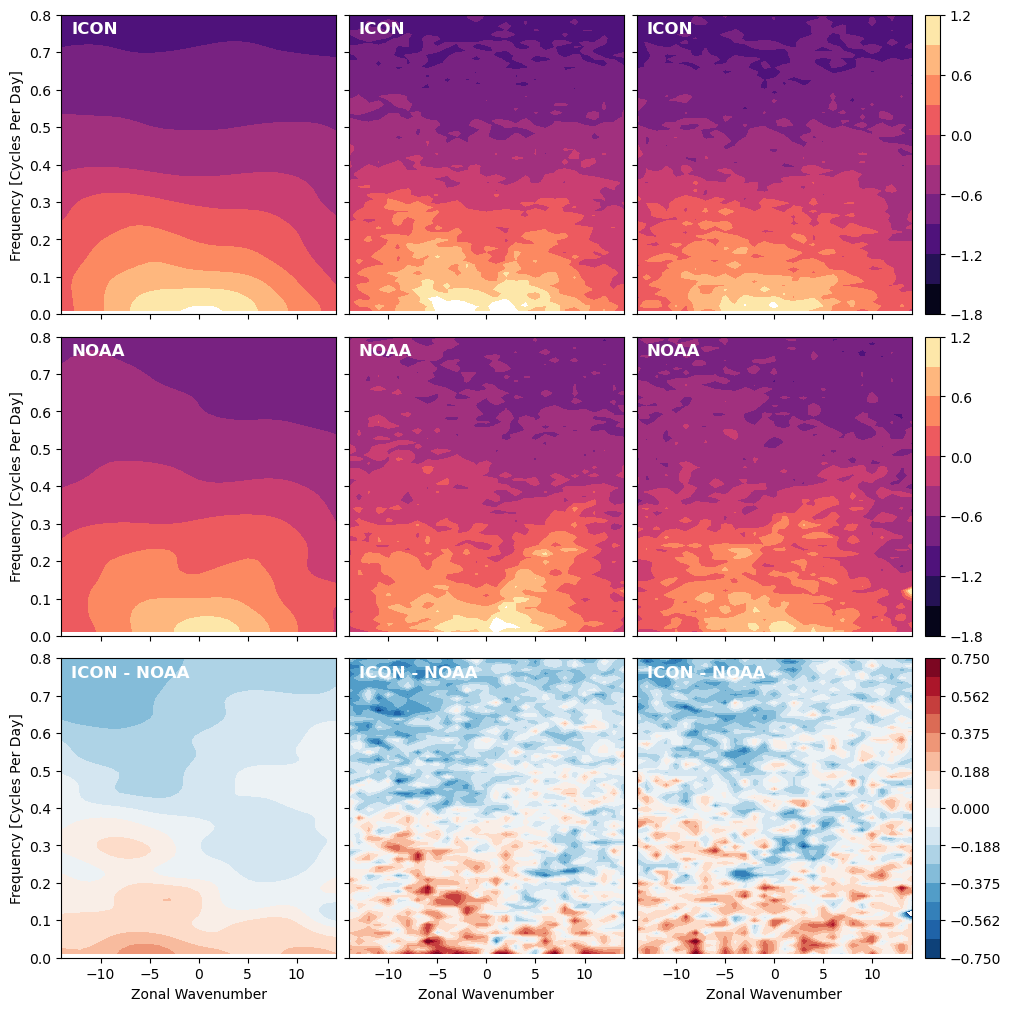

In [16]:
# plot spectra
fig, axs = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)

k = icon_background.wavenumber
w = icon_background.frequency
spectrum_levels = np.linspace(-1.8, 1.2, 11)
diff_levels = np.linspace(-0.75, 0.75, 17)

axs[0, 0].contourf(
    k,
    w,
    np.log10(icon_background.values),
    levels=spectrum_levels,
    cmap="magma",
)
axs[0, 0].set_xticklabels([])
axs[0, 0].set_ylabel("Frequency [Cycles Per Day]")
axs[0, 0].annotate(
    "ICON",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
axs[0, 1].contourf(
    k, w, np.log10(icon_symmetric.values), levels=spectrum_levels, cmap="magma"
)
axs[0, 1].set_xticklabels([])
axs[0, 1].set_yticklabels([])
axs[0, 1].annotate(
    "ICON",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
cs = axs[0, 2].contourf(
    k,
    w,
    np.log10(icon_asymmetric.values),
    levels=spectrum_levels,
    cmap="magma",
)
axs[0, 2].set_xticklabels([])
axs[0, 2].set_yticklabels([])
axs[0, 2].annotate(
    "ICON",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
fig.colorbar(cs, ax=axs[0, 2])

k = noaa_background.wavenumber
w = noaa_background.frequency
axs[1, 0].contourf(
    k,
    w,
    np.log10(noaa_background.values),
    levels=spectrum_levels,
    cmap="magma",
)
axs[1, 0].set_xticklabels([])
axs[1, 0].set_ylabel("Frequency [Cycles Per Day]")
axs[1, 0].annotate(
    "NOAA",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
axs[1, 1].contourf(
    k, w, np.log10(noaa_symmetric.values), levels=spectrum_levels, cmap="magma"
)
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].annotate(
    "NOAA",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
cs = axs[1, 2].contourf(
    k,
    w,
    np.log10(noaa_asymmetric.values),
    levels=spectrum_levels,
    cmap="magma",
)
axs[1, 2].set_xticklabels([])
axs[1, 2].set_yticklabels([])
axs[1, 2].annotate(
    "NOAA",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
fig.colorbar(cs, ax=axs[1, 2])

axs[2, 0].contourf(
    k, w, diff_background.values, levels=diff_levels, cmap="RdBu_r"
)
axs[2, 0].set_xlabel("Zonal Wavenumber")
axs[2, 0].set_ylabel("Frequency [Cycles Per Day]")
axs[2, 0].annotate(
    "ICON - NOAA",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
axs[2, 1].contourf(
    k, w, diff_symmetric.values, levels=diff_levels, cmap="RdBu_r"
)
axs[2, 1].set_yticklabels([])
axs[2, 1].set_xlabel("Zonal Wavenumber")
axs[2, 1].annotate(
    "ICON - NOAA",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
cs = axs[2, 2].contourf(
    k, w, diff_asymmetric.values, levels=diff_levels, cmap="RdBu_r"
)
axs[2, 2].set_yticklabels([])
axs[2, 2].set_xlabel("Zonal Wavenumber")
axs[2, 2].annotate(
    "ICON - NOAA",
    xy=(-13, 0.75),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="w",
)
fig.colorbar(cs, ax=axs[2, 2])

for ax in axs.ravel():
    ax.set_xlim(-14, 14)
    ax.set_ylim(0, 0.8)

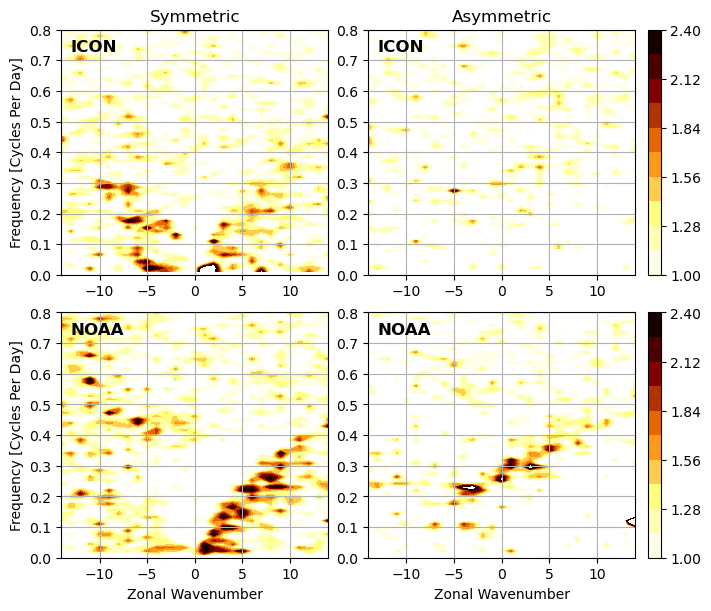

In [17]:
# plot spectrum
fig, axs = plt.subplots(2, 2, figsize=(7.0, 6), constrained_layout=True)

k = icon_background.wavenumber
w = icon_background.frequency
spectrum_levels = np.linspace(1.0, 2.4, 11)
diff_levels = np.linspace(-0.5, 0.5, 11)

axs[0, 0].set_title("Symmetric")
axs[0, 0].annotate(
    "ICON",
    xy=(-13, 0.73),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="k",
)
axs[0, 1].set_title("Asymmetric")
axs[0, 1].annotate(
    "ICON",
    xy=(-13, 0.73),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="k",
)
axs[0, 0].contourf(
    k, w, icon_symmetric_peaks.values, levels=spectrum_levels, cmap="afmhot_r"
)
cs = axs[0, 1].contourf(
    k, w, icon_asymmetric_peaks.values, levels=spectrum_levels, cmap="afmhot_r"
)
fig.colorbar(cs, ax=axs[0, 1])
axs[0, 0].set_ylabel("Frequency [Cycles Per Day]")

noaa_symmetric_peaks_plot = noaa_symmetric_peaks.values
noaa_symmetric_peaks_plot[noaa_symmetric_peaks_plot > spectrum_levels[-1]] = (
    spectrum_levels[-1]
)
axs[1, 0].contourf(
    k, w, noaa_symmetric_peaks_plot, levels=spectrum_levels, cmap="afmhot_r"
)
axs[1, 0].annotate(
    "NOAA",
    xy=(-13, 0.73),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="k",
)
cs = axs[1, 1].contourf(
    k, w, noaa_asymmetric_peaks.values, levels=spectrum_levels, cmap="afmhot_r"
)
axs[1, 1].annotate(
    "NOAA",
    xy=(-13, 0.73),
    xycoords="data",
    fontsize=12,
    fontweight="bold",
    color="k",
)
fig.colorbar(cs, ax=axs[1, 1])
axs[1, 0].set_ylabel("Frequency [Cycles Per Day]")

axs[1, 0].set_xlabel("Zonal Wavenumber")
axs[1, 1].set_xlabel("Zonal Wavenumber")

for i, ax in enumerate(axs.ravel()):
    ax.grid()
    ax.set_xlim(-14, 14)
    ax.set_ylim(0, 0.8)

In [18]:
def plot_map(lat, lon, data, fig, ax, transform, **kwargs):
    cyclic_data, cyclic_lons = add_cyclic_point(data, coord=lon)
    cf = ax.contourf(
        cyclic_lons, lat, cyclic_data, transform=transform, **kwargs
    )
    fig.colorbar(cf, ax=ax, label="[$W/m^2$]")
    ax.coastlines()
    gridlines = ax.gridlines(
        crs=transform,
        draw_labels=True,
        color="gray",
        alpha=0.5,
        linestyle="--",
    )
    gridlines.top_labels = False
    gridlines.left_labels = True

Text(-174, 10, 'NOAA')

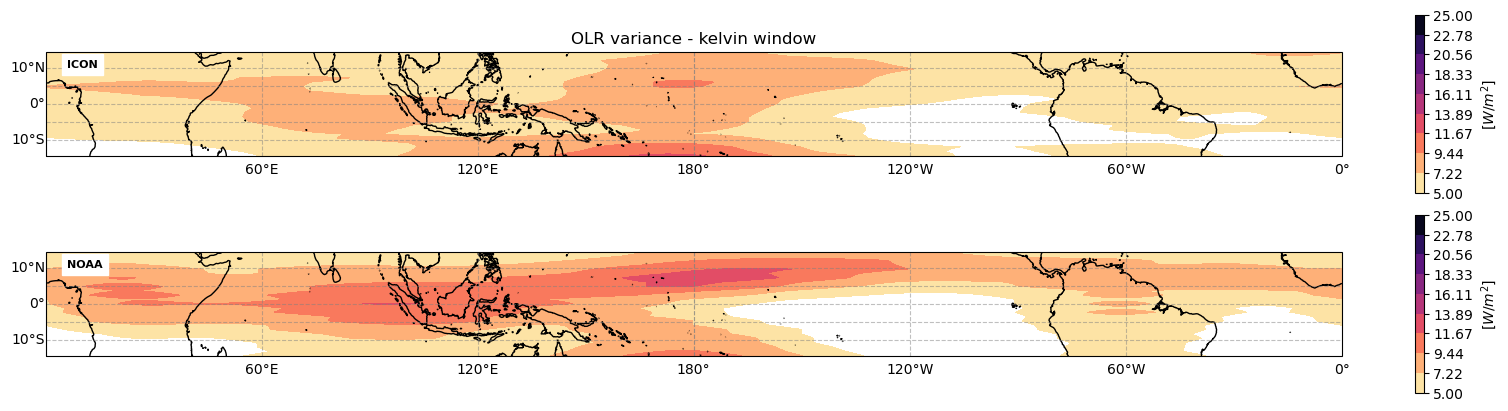

In [19]:
std_vmin = 5
std_vmax = 25
std_steps = 10
std_levels = np.linspace(std_vmin, std_vmax, std_steps)

window_name = "kelvin"  # mjo, kelvin, tropical_depression, inertio_gravity, mixed_rossby_gravity, equatorial_rossby
projection = ccrs.PlateCarree(central_longitude=-180)
transform = ccrs.PlateCarree()
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    figsize=(15, 4),
    subplot_kw={"projection": projection},
    constrained_layout=True,
)
icon_array = filtered_icon[window_name].std("time").values.T
noaa_array = filtered_noaa[window_name].std("time").values.T


title = f"OLR variance - {window_name} window"
plot_map(
    filtered_icon.lat.values,
    filtered_icon.lon.values,
    icon_array,
    fig,
    ax1,
    transform,
    levels=std_levels,
    cmap="magma_r",
)
ax1.annotate(
    "ICON",
    xy=(-174, 10),
    xycoords="data",
    fontsize=8,
    fontweight="bold",
    backgroundcolor="w",
)
ax1.set_title(title)
plot_map(
    filtered_noaa.lat.values,
    filtered_noaa.lon.values,
    noaa_array,
    fig,
    ax2,
    transform,
    levels=std_levels,
    cmap="magma_r",
)
ax2.annotate(
    "NOAA",
    xy=(-174, 10),
    xycoords="data",
    fontsize=8,
    fontweight="bold",
    backgroundcolor="w",
)